# Porosity analysis, segmentation

This notebook is developed for the course 02509, week 6. The notebook runs on Google colab, and the students should have it running on the DTU G-bar cluster.

## Running the notebook on G-bar (one way)

* Log on G-bar using ThinLinc client
* Copy the notebook to a folder you have access to
* Open the terminal (Applications -> System -> Terminal)
* Start course node `02509sh -X`
* Navigate to `/dtu/3d-imaging-center/courses`
* Launch initialization script `conda/conda-init.sh`
* Activate the environment `conda activate env-02509`
* Navigate to the folder where you placed the notebook
* Start notebook `jupyter-notebook`

Furthermore, if you are at DTU G-bar, you don't need to retrieve the data, instead find data in following directory:
```
'/dtu/3d-imaging-center/courses/02509/data/Cement/' 
```


In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import tifffile
import skimage.filters
import skimage.measure
import scipy


In [2]:
# If needed, retrieve volume from QIM data repository. 
# This may take a couple of minutes, but is only done once.
import os
if not os.path.isfile('hourglass_crop.tiff'):
    !wget -q https://qim.compute.dtu.dk/data-repository/hourglass_crop.tiff.zip

    # Unzip the file to the current directory.
    import shutil
    shutil.unpack_archive('hourglass_crop.tiff.zip')

In [3]:
# Load data.
vol = tifffile.imread('hourglass_crop.tiff')
Z, Y, X = vol.shape
dtype = vol.dtype
print(f'Tiff file has {Z} slices of shape ({Y}, {X}). Data type is {dtype}.')

# Crop a smaller part of the data.
# vol = vol[100:300, 100:300, 100:300]
# Z, Y, X = vol.shape
# print(f'Tiff file has {Z} slices of shape ({Y}, {X}). Data type is {dtype}.')

Tiff file has 400 slices of shape (400, 400). Data type is uint8.


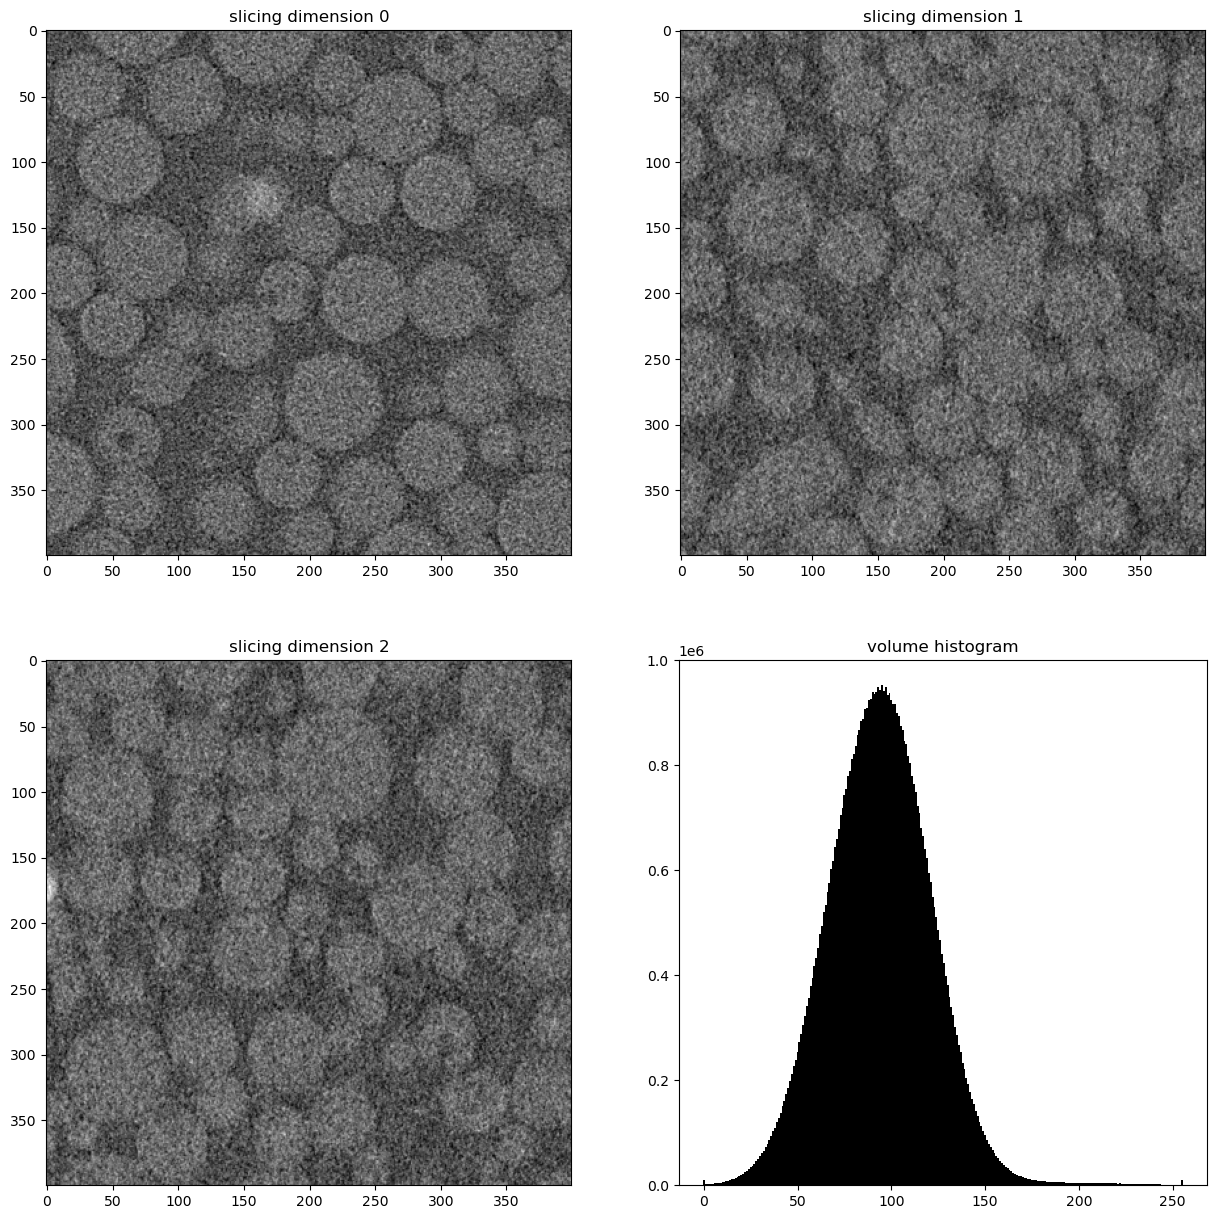

In [4]:
# Look at three orthogonal cross-sections and histogram.

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax = ax.ravel()
ax[0].imshow(vol[Z//2], cmap=plt.cm.gray, vmin=0, vmax=255)
ax[0].set_title('slicing dimension 0')
ax[1].imshow(vol[:, Y//2, :], cmap=plt.cm.gray, vmin=0, vmax=255)
ax[1].set_title('slicing dimension 1')
ax[2].imshow(vol[:, :, X//2], cmap=plt.cm.gray, vmin=0, vmax=255)
ax[2].set_title('slicing dimension 2')
edges = np.arange(257)-0.5
centers = np.arange(256)
hist = np.histogram(vol.ravel(), edges)[0]
ax[3].bar(centers, hist, width=1, color='k')
ax[3].set_title('volume histogram')
plt.show()


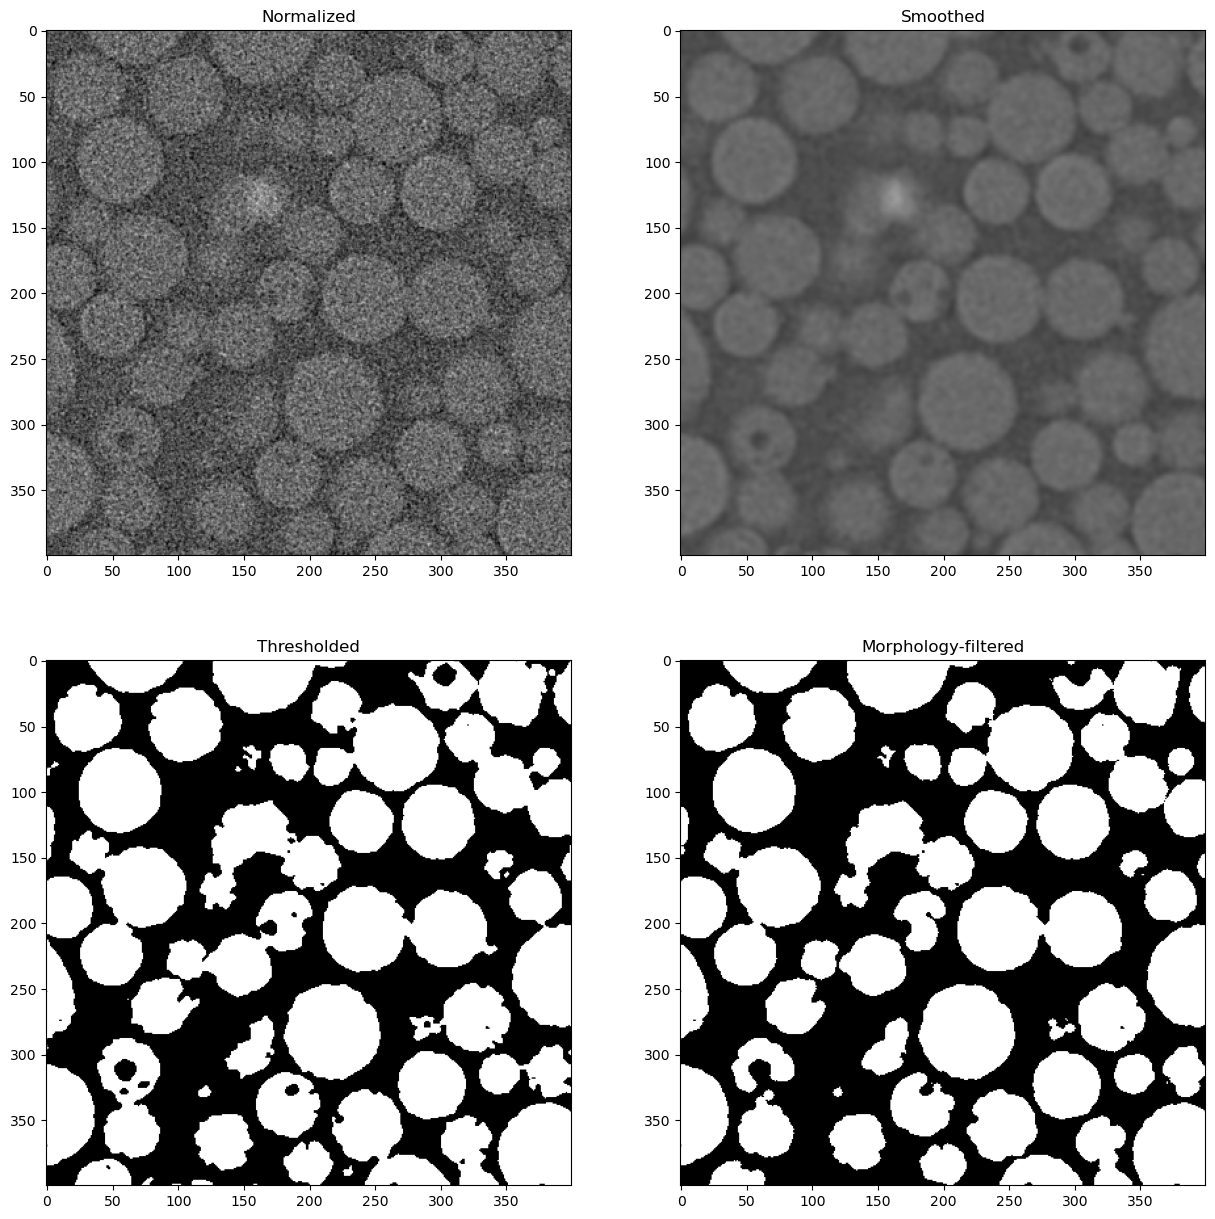

In [5]:
# Binarize the volume and visualize all processing steps on one slice.

bin_vol = vol

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax = ax.ravel()

bin_vol = bin_vol.astype(float)/255
ax[0].imshow(bin_vol[Z//2, ], cmap=plt.cm.gray, vmin=0, vmax=1)
ax[0].set_title('Normalized')

bin_vol = skimage.filters.gaussian(bin_vol, sigma=2)
ax[1].imshow(bin_vol[Z//2], cmap=plt.cm.gray, vmin=0, vmax=1)
ax[1].set_title('Smoothed')

bin_vol = bin_vol > 95/255
ax[2].imshow(bin_vol[Z//2], cmap=plt.cm.gray)
ax[2].set_title('Thresholded')

bin_vol = skimage.morphology.binary_opening(bin_vol, skimage.morphology.ball(5))
ax[3].imshow(bin_vol[Z//2], cmap=plt.cm.gray)
ax[3].set_title('Morphology-filtered')

plt.show()


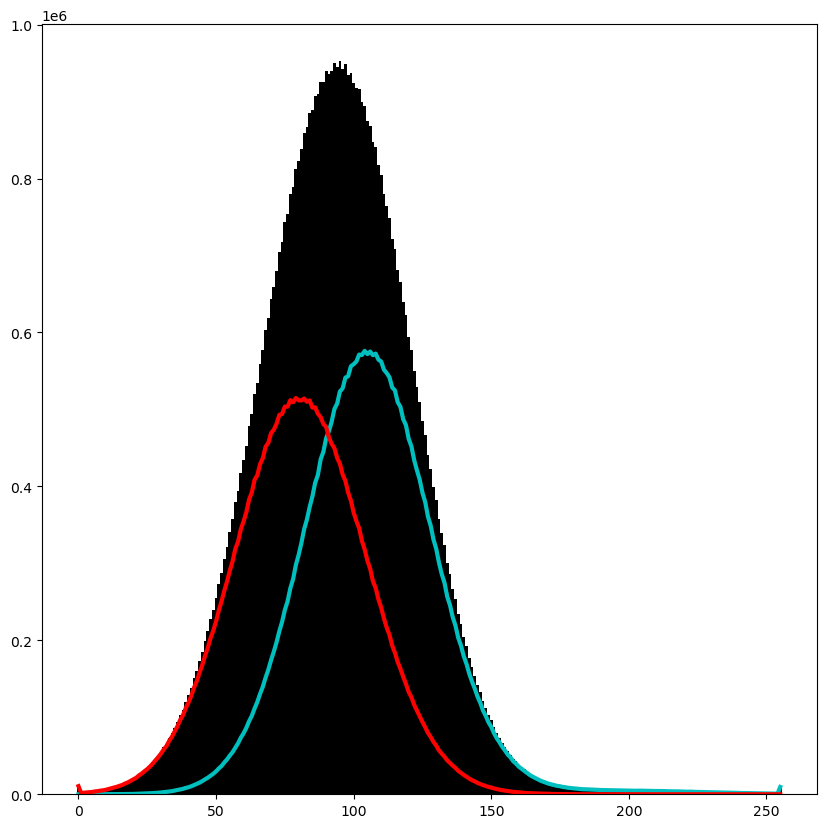

In [6]:
# Investigate how this segmentation unmixes volume histogram.
fig, ax = plt.subplots(figsize=(10, 10))

edges = np.arange(257)-0.5
centers = np.arange(256)
hist = np.histogram(vol.ravel(), edges)[0]
ax.bar(centers, hist, width=1, color='k')
ax.plot(centers, np.histogram(vol[bin_vol].ravel(), edges)[0], 'c', lw=3)
ax.plot(centers, np.histogram(vol[~bin_vol].ravel(), edges)[0], 'r', lw=3)
plt.show()




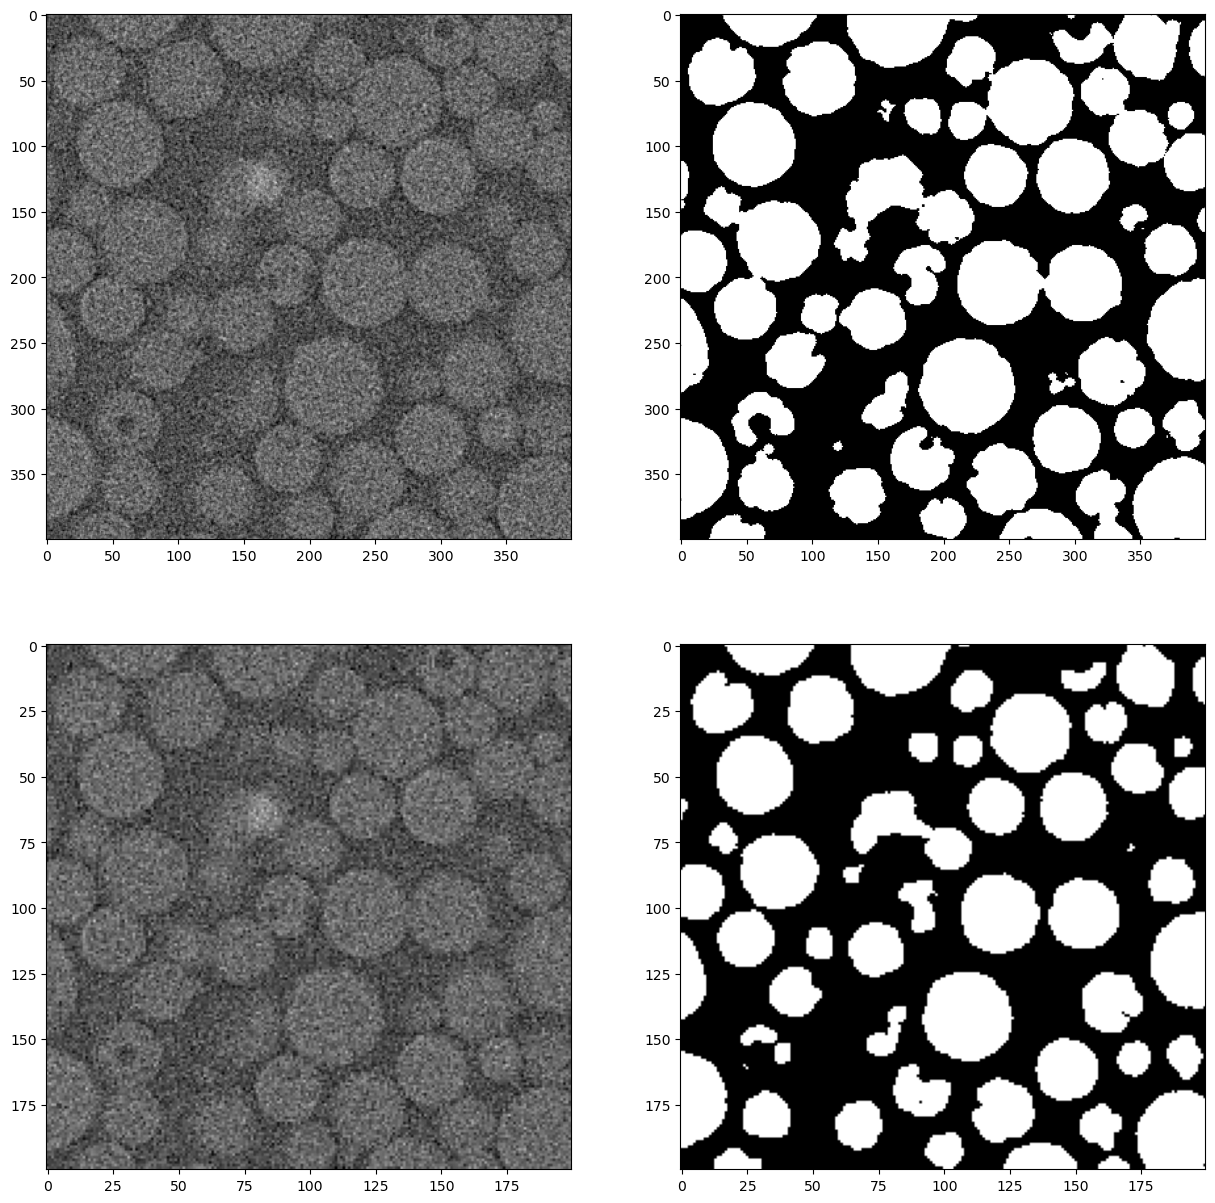

In [7]:
# Downsample for speed, and process some bit more

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax = ax.ravel()
ax[0].imshow(vol[Z//2], vmin=0, vmax=255, cmap=plt.cm.gray)
ax[1].imshow(bin_vol[Z//2], cmap=plt.cm.gray)
vol = vol[::2, ::2, ::2]
bin_vol = bin_vol[::2, ::2, ::2]
bin_vol = skimage.morphology.binary_closing(bin_vol, skimage.morphology.ball(1))
bin_vol = skimage.morphology.binary_erosion(bin_vol, skimage.morphology.ball(1))
bin_vol = skimage.morphology.binary_opening(bin_vol, skimage.morphology.ball(3))
Z, Y, X = vol.shape
ax[2].imshow(vol[Z//2], vmin=0, vmax=255, cmap=plt.cm.gray)
ax[3].imshow(bin_vol[Z//2], cmap=plt.cm.gray)
plt.show()

In [8]:
tifffile.imwrite('hourglass_temp_vol.tiff', vol)
tifffile.imwrite('hourglass_temp_bin_vol.tiff', 255*bin_vol.astype(np.uint8))